In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from qubic.lib.Qgps import GPS
import Qgps_alt as gps_alt

%matplotlib widget

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [ ]:
data_path = "calsource_orientation_20240322.dat"
position_qubic = np.array([1, -1.3, -1.5])
distance_between_antennas = 1
distance_calsource = 0.5
observation_date = np.array([dt.datetime(2024, 3, 22, 9, 47, 49), dt.datetime(2024, 3, 22, 16, 13, 49, 500000)])#np.array([dt.datetime(2024, 3, 22, 10, 8, 00)]) #

In [3]:
gps = GPS(data_path, distance_between_antennas, distance_calsource, observation_date, position_qubic=position_qubic)

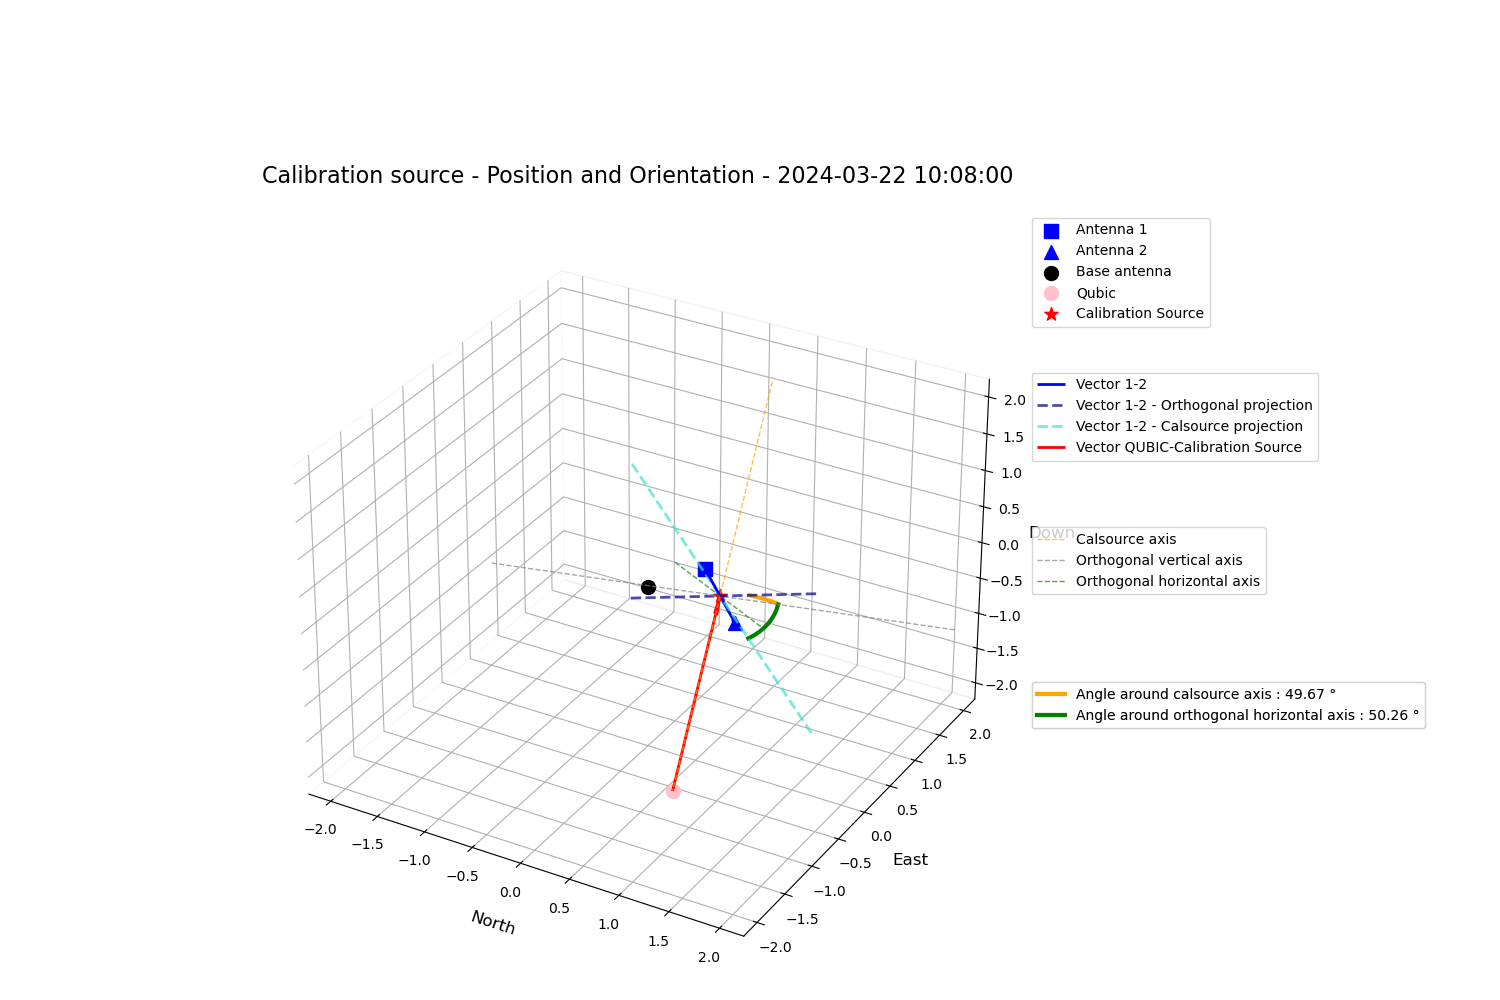

In [4]:
gps.plot_system()

In [5]:
gps_test = gps_alt.GPS(data_path, gps.position_antenna1, gps.position_antenna2, gps.position_calsource, observation_date)

(3, 1)
R_north [[1 0 0]
 [0 array([1.]) array([-0.])]
 [0 array([0.]) array([1.])]]
(3, 3)
[[array([0.27366321])]
 [array([-0.849834])]
 [array([0.01536715])]]


TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable sqrt method